##### Goal of the model
* Understand how we can group our product ids
* Find out possible marketing strategies tailored to each cluster

##### Importing Packages

In [1]:
import pandas as pd
import json
from sklearn import cluster
from sklearn import metrics
import seaborn
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
import sqlalchemy

##### Fetching tb_products from our database

In [2]:
DB_PATH = r"C:\Users\jpgsa\Documents\GitHub\autodoc-task\autodoc-task-jan-2024\database_files\task_dataset.db"
engine = sqlalchemy.create_engine("sqlite:///" + DB_PATH)
table = "tb_products"

df_products = pd.read_sql_table(table, engine)
df_products.head()

,product_id,sessions_a2b_qty,sessions_with_order,events_a2b_qty,events_pdp_a2b_qty,events_plp_a2b_qty,events_search_plp_a2b_qty,pages_before_a2b_qty,pdp_before_a2b_qty,plp_before_a2b_qty,search_plp_before_a2b_qty
0,26372760,21,12,21,20,0,1,58,38,5,13
1,27133309,20,0,20,20,0,0,20,20,0,0
2,20053168,13,0,13,13,0,0,14,14,0,0
3,31845429,12,2,12,11,0,1,30,25,2,3
4,20283956,11,4,13,10,0,3,62,31,6,25


##### Creates Model

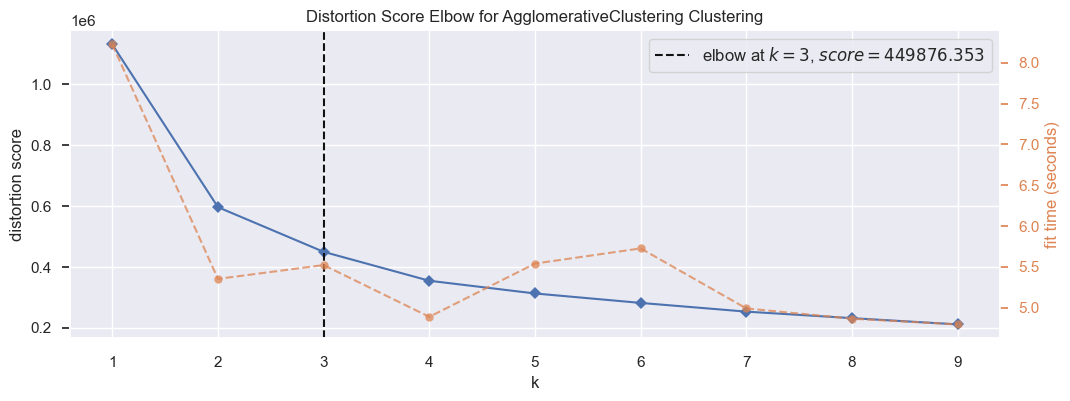

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [77]:
features = df_products.columns[1:]
model = cluster.AgglomerativeClustering()

## KElbowVisualizer retrieves the ideal number of clusters
visualizer = KElbowVisualizer(model, k = (1,10))
visualizer.fit(df_products[features])
visualizer.show() 

In [11]:
# Now we can use the ideal number of clusters
model = cluster.AgglomerativeClustering(n_clusters=3)
model.fit(df_products[features])

df_products["cluster_id"] = model.labels_
df_products.groupby("cluster_id").count()["product_id"]

cluster_id
0     836
1    2034
2    9571
Name: product_id, dtype: int64

##### Checking the features heatmap across clusters

<Axes: ylabel='cluster_id'>

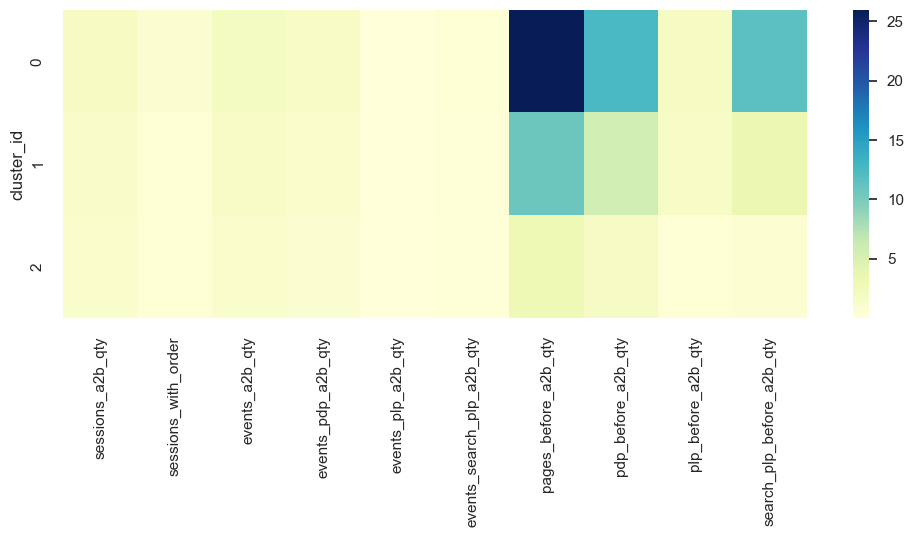

In [49]:
seaborn.set(rc={'figure.figsize':(12,4)})
features_cluster = df_products.columns[1:]
seaborn.heatmap(df_products[features_cluster].groupby("cluster_id").mean(),cmap="YlGnBu")

##### New approach, we'll only use "pages before atb" as features

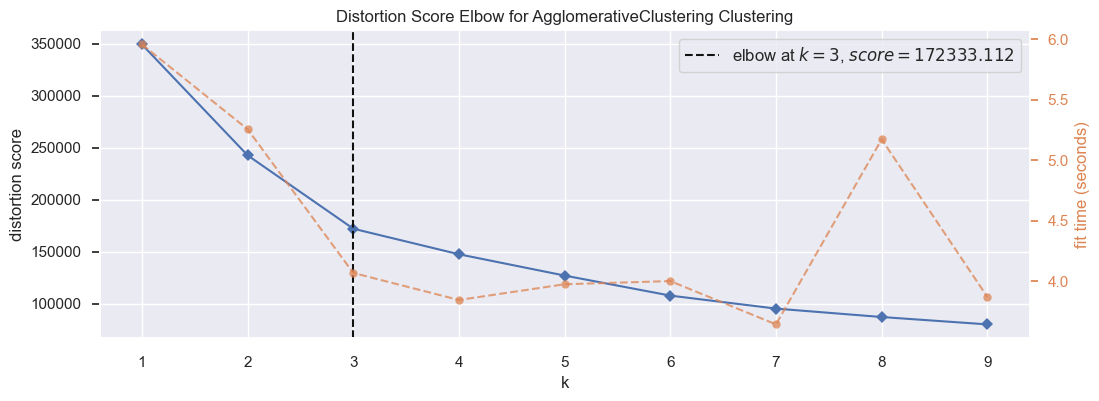

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:

# We'll first normalize as to have "average pages before a2b" since currently its the sum from all sessions
df_products["avg_pdp_before_a2b_qty"] = df_products["pdp_before_a2b_qty"] /df_products["sessions_a2b_qty"] 
df_products["avg_plp_before_a2b_qty"] = df_products["plp_before_a2b_qty"] /df_products["sessions_a2b_qty"] 
df_products["avg_search_plp_before_a2b_qty"] = df_products["search_plp_before_a2b_qty"] /df_products["sessions_a2b_qty"] 
df_products["avg_pages_before_a2b_qty"] = df_products["pages_before_a2b_qty"] /df_products["sessions_a2b_qty"] 
df_products["avg_sessions_with_order"] = df_products["sessions_with_order"] /df_products["sessions_a2b_qty"] 

new_features = ["avg_pdp_before_a2b_qty",
                "avg_plp_before_a2b_qty",
                "avg_search_plp_before_a2b_qty"]

model = cluster.AgglomerativeClustering()

## KElbowVisualizer retrieves the ideal number of clusters
visualizer = KElbowVisualizer(model, k = (1,10))
visualizer.fit(df_products[new_features])
visualizer.show() 

In [20]:
# Now we can use the ideal number of clusters
model = cluster.AgglomerativeClustering(n_clusters=3)
model.fit(df_products[new_features])

df_products["cluster_id_2"] = model.labels_
df_products.groupby("cluster_id_2").count()["product_id"]

cluster_id_2
0      977
1    10793
2      671
Name: product_id, dtype: int64

##### Checking the features heatmap across clusters

<Axes: ylabel='cluster_id_2'>

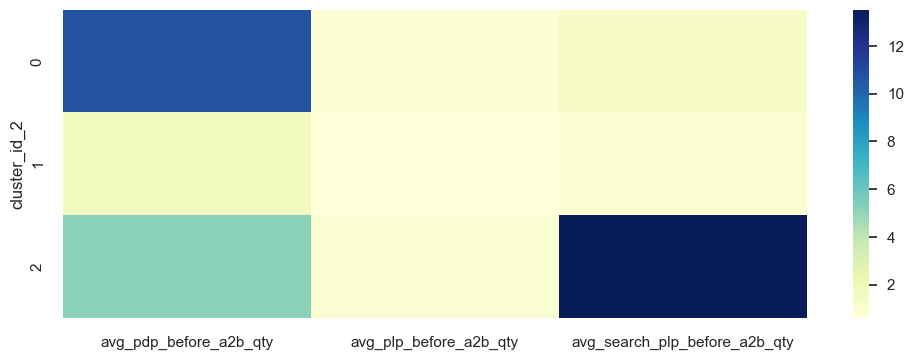

In [22]:
seaborn.set(rc={'figure.figsize':(12,4)})

features_cluster2 = []
for feature in new_features: features_cluster2.append(feature)
features_cluster2.append("cluster_id_2")

seaborn.heatmap(df_products[features_cluster2].groupby("cluster_id_2").mean(),cmap="YlGnBu")

In [31]:
df_products.groupby("cluster_id_2").mean()[new_features + ["avg_pages_before_a2b_qty","avg_sessions_with_order"]]

,avg_pdp_before_a2b_qty,avg_plp_before_a2b_qty,avg_search_plp_before_a2b_qty,avg_pages_before_a2b_qty,avg_sessions_with_order
cluster_id_2,,,,,
0,10.696145,0.912794,1.395087,13.004026,0.504367
1,1.719856,0.615171,0.927223,3.275846,0.411529
2,5.172876,1.041977,13.516145,19.730999,0.463612


##### Conclusions

##### Cluster 0 - Long PDP-to-PDP navigation until ATC (# 977 products)

* 0.50 "sessions with order" rate (highest)
* Takes ~13 pages until ATC, mostly product
* We should improve these products discoverability by optimizing listings (visual merchandise & ranking algorithms) + adding or improving product recommendations

##### Cluster 1 - Quick ATC but low order conversion (# 10,793 products)
* 0.41 "sessions with order" rate (lowest)
* Takes ~3 pages until ATC
* We're potentially promoting these products with direct links to PDP but they don't convert as much. We may need to optimize our product selection for campaigns: remove items with low performance and include new ones from the previous cluster (0).


##### Cluster 2 - Long Search-to-Search journey with mid order conversion (# 671 products)
* 0.46 "sessions with order" rate (mid)
* Takes ~20 pages until ATC, mostly search
* We should fetch the properties/keywords of these items and improve our search engine as such